In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [54]:
from tqdm.notebook import tqdm
from IPython.display import Video
from collections import deque

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import cv2
import math
import os
import sys
import time
import re
import glob
import imageio
import bz2
import pickle

tqdm.pandas()

In [55]:
# DATASET_FOLDER = 'C:/Users/markw/Downloads/20bn-jester-v1'
DATASET_FOLDER = 'C:/Users/markw/Downloads/ngt_10fps_val'

# df = pd.read_pickle('MFF-pytorch/datasets/jester-v1/jester_df.pkl')
df = pd.read_excel('ngt_signbank_validation_filtered_300.xlsx')

In [56]:
display(df)

,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),Annotation ID Gloss (Dutch),Annotation ID Gloss (English),Keywords (Dutch),...,Is this a proposed new sign?,SignLanguages,Dialects,Sequential Morphology,Simultaneous Morphology,Blend Morphology,Relations to other signs,Relations to foreign signs,Tags,Notes
0,0,X,Mark,1239,NGT,OUDERWETS,NaN,OUDERWETS,OLD-FASHIONED,"antiek, klassiek, ouderwets",...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,X,Mark,2824,NGT,BAARD-A,NaN,BAARD-A,BEARD-A,baard,...,False,NaN,NaN,NaN,NaN,NaN,"variant:2825, variant:4521",NaN,NaN,NaN
2,2,X,Mark,4536,NGT,BREKEN,NaN,BREKEN-D,BREAK-D,breken,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,project: FMU,NaN
3,3,X,Mark,1358,NGT,EXAMEN,NaN,EXAMEN,EXAM,examen,...,False,NaN,NaN,NaN,NaN,NaN,"homonym:1360, homonym:1369",NaN,NaN,NaN
4,4,X,Mark,1398,NGT,AMSTEL-B,NaN,AMSTEL-B,AMSTEL-B,Amstel bier,...,False,NaN,NaN,NaN,NaN,NaN,variant:261,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,NaN,NaN,2950,NGT,KNIE,NaN,KNIE,KNEE,knie,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,project: FMU,NaN
296,296,NaN,NaN,3961,NGT,HAND-OP-BORST,NaN,HAND-OP-BORST,HAND-ON-CHEST,"ach, behoefte, emotie, gevoel, gevoelens, mijn...",...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Etymology: (False,1,gesture), Note: (True,1,mi..."
297,297,NaN,NaN,620,NGT,WERELD-A,NaN,WERELD-A,WORLD-A,wereld,...,False,NaN,NaN,NaN,NaN,NaN,"variant:1029, variant:1030",NaN,NaN,"Phonology: (False,0,handvorm)"
298,298,NaN,NaN,422,NGT,DOLLAR-A,NaN,DOLLAR-A,DOLLAR-A,"dollar, geldteken",...,False,NaN,NaN,NaN,NaN,NaN,variant:1648,NaN,NaN,NaN


In [57]:
if 'folder' not in df.columns:
    SIGNBANK2FOLDER_DICT = pd.read_pickle(f'train_ngt_dxy_10fps.pkl').set_index('Signbank ID')['folder_index'].to_dict()
    df['folder'] = df['Signbank ID'].map(SIGNBANK2FOLDER_DICT)
    
    # get number of frames for each video
    def count_n_frames(folder_name, postfix=''):
        return len(glob.glob(f'{DATASET_FOLDER}{postfix}/rgb/{folder_name}/*'))
    
    df['n_frames'] = df['folder'].apply(count_n_frames)

In [69]:
def load_of_stats(folder):
    print(f'folder: {folder}')
    with bz2.BZ2File(f'{DATASET_FOLDER}/flow/stats/{folder}.pkl', 'rb') as f:
        return pickle.load(f)
        
# row = jester_df.loc[jester_df['subset'] == 'val'].sample(1).squeeze()
row = df.loc[df['Signbank ID'] == 27].sample(1).squeeze()
n_frames = row['n_frames']
folder = row['folder']
res = load_of_stats(folder)
display(row)

folder: 1140


ID                             228
is_val                           X
Person                        Onno
Signbank ID                     27
Dataset                        NGT
                              ... 
Relations to foreign signs     NaN
Tags                           NaN
Notes                          NaN
folder                        1140
n_frames                        40
Name: 228, Length: 70, dtype: object

In [70]:
def add_rolling_n_of_stats(of_stats):
    of_stats_copy = dict( { 'x': dict(), 'y': dict() } )
    for axis, of_stats_axis in list(of_stats.items()):
        for k, v in list(of_stats_axis.items()):
            for n in [1,2,3,4,5]:
                v_rn = []
                r = deque(maxlen=n)
                for i in v:
                    r.append(i)
                    v_rn.append(np.array(r).mean())
                # add to of_stats
                of_stats_copy[axis][k] = v
                of_stats_copy[axis][f'{k}_r{n}'] = v_rn
                
    return of_stats_copy

res = add_rolling_n_of_stats(res)

key: mins


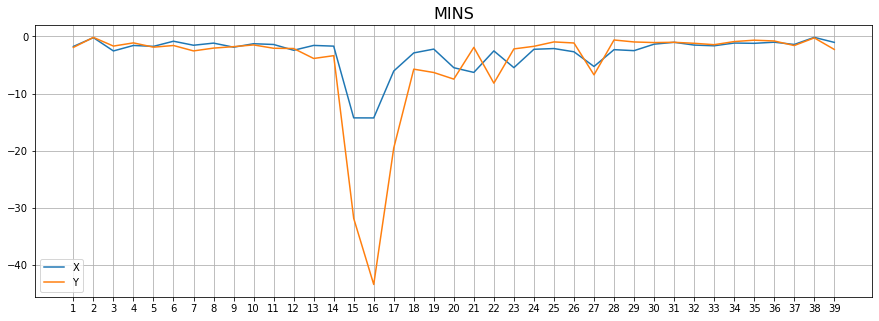

key: maxs


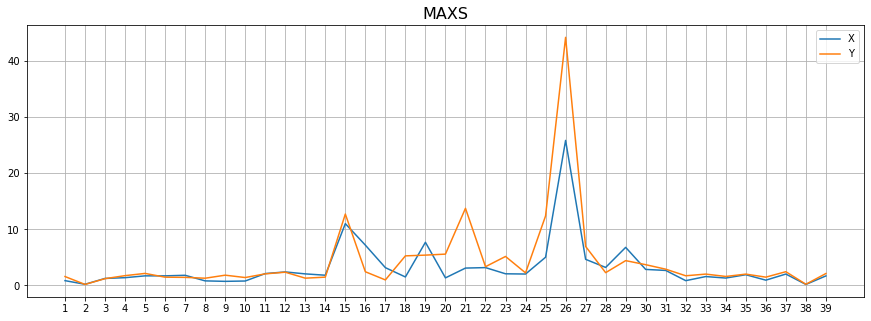

key: means


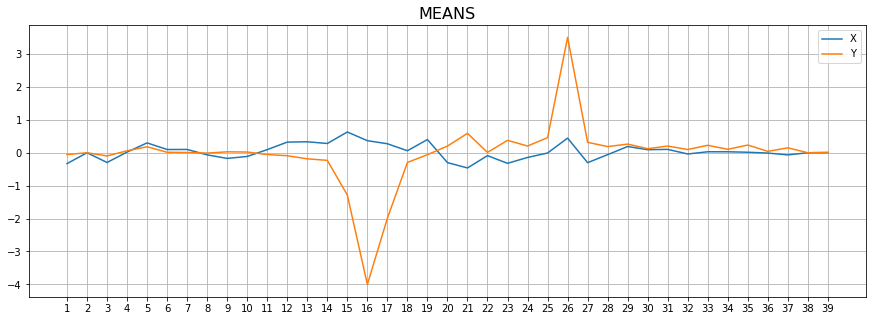

key: medians


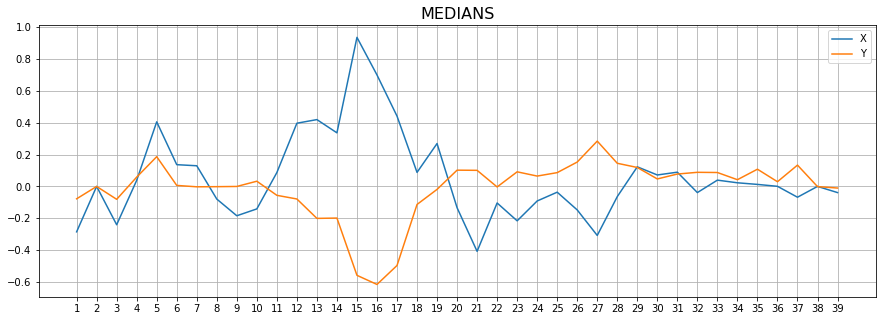

key: stds


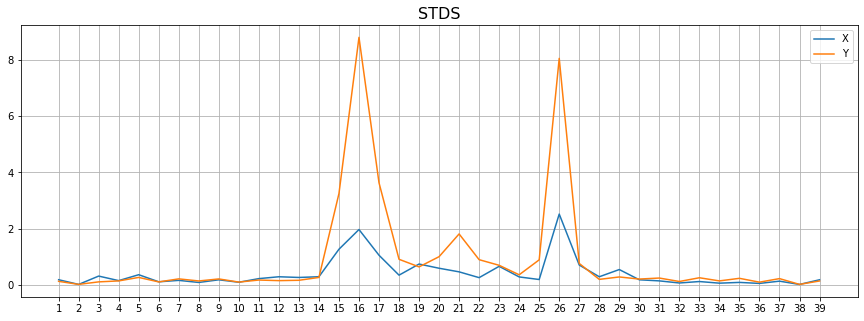

In [71]:
rn = 1
for key in ['mins', 'maxs', 'means', 'medians', 'stds']:
    print(f'key: {key}')
    frame_idxs = np.arange(1, n_frames)
    plt.figure(figsize=(15,5))
    plt.plot(frame_idxs, res['x'][f'{key}_r{rn}'], label='X')
    plt.plot(frame_idxs, res['y'][f'{key}_r{rn}'], label='Y')
    plt.title(key.upper(), size=16)
    plt.legend()
    plt.grid()
    plt.xticks(frame_idxs)
    plt.show()

In [72]:
def get_start_end_frame_idx(of_stats, n_frames, threshold=0.10):
    of_std_max = max(of_stats['x'][f'stds'] + of_stats['y'][f'stds'])
    # Start Frame Index
    start_idx = 1
    for of_x_std, of_y_std in zip(of_stats['x'][f'stds'], of_stats['y'][f'stds']):
        if max(of_x_std, of_y_std) < of_std_max * threshold:
            start_idx += 1
        else:
            break
          
    # End Frame Index
    end_idx = n_frames - 2 # zero index minus last frame
    for of_x_std, of_y_std in zip(reversed(of_stats['x'][f'stds']), reversed(of_stats['y'][f'stds'])):
        if max(of_x_std, of_y_std) < of_std_max * threshold:
            end_idx -= 1
        else:
            break
            
    # start idx of first OF above threshold
    # end idx + 1, RGB frame with OF frame above threshold
    return start_idx, end_idx + 1

get_start_end_frame_idx(res, n_frames)

(15, 26)

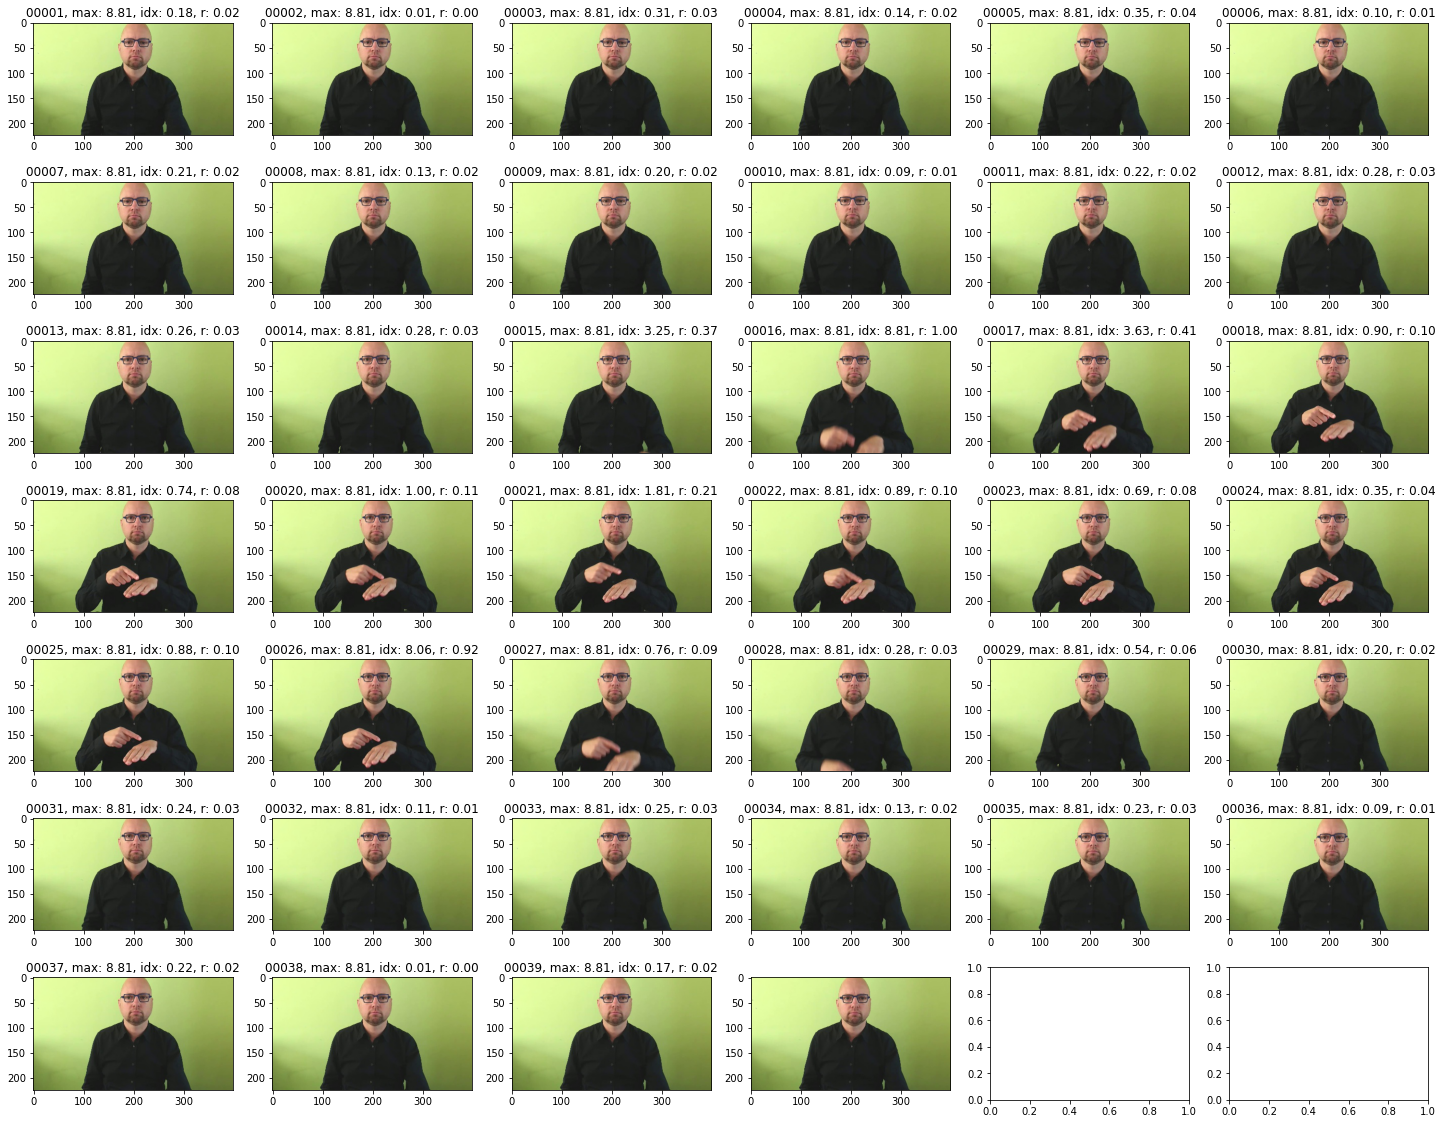

In [73]:
cols = math.ceil(n_frames / 6)
rows = 6
fig, ax = plt.subplots(cols, rows, figsize=(25, 20))

# compute max optical flow std
of_std_max = max(res['x'][f'stds'] + res['y'][f'stds'])

for idx in range(0, n_frames):
    frame_number = f'{idx + 1}'.rjust(5, '0')
    row_idx, col_idx = idx // rows, idx % rows
    ax[row_idx, col_idx].imshow(imageio.imread(f'{DATASET_FOLDER}/rgb/{folder}/{frame_number}.jpg'))
    # last image doesn't have OF frame
    if idx < n_frames - 1:
        idx_of_std_max = max(res['x'][f'stds'][idx], res['y'][f'stds'][idx])
        ax[row_idx, col_idx].set_title(f'{frame_number}, max: {of_std_max:.2f}, idx: {idx_of_std_max:.2f}, r: {(idx_of_std_max / of_std_max):.2f}')
plt.show()

# Pickle Gen

In [78]:
TARGET_IMG_SIZE = 224
N_MFF_FRAMES = 4
N_OPTICAL_FLOW_FRAMES = 3
N_FRAMES = 3 + N_OPTICAL_FLOW_FRAMES * 2
N_IMAGES = 1 + N_OPTICAL_FLOW_FRAMES * 2
N_TIME_POINTS = 1 + N_OPTICAL_FLOW_FRAMES

In [79]:
# get keyframes, linear based
def get_keyframe_idxs_of_kfe(folder, n_frames, debug=False):
    of_stats = res
    start_idx, end_idx = get_start_end_frame_idx(of_stats, n_frames)
    if debug:
        print(f'start_idx: {start_idx}, end_idx: {end_idx}')
    
    # Get Start Index Ignoring Duplicate Frames
    OF_FRAME_COUNT = 0
    for i in range(start_idx, n_frames):
        frame_number = f'{i + 1}'.rjust(5, '0')
        of_std = imageio.imread(f'{DATASET_FOLDER}/flow/x/{folder}/{frame_number}.jpg').std()
        if of_std > 0: # IFF OF STD is non zero frame is non duplicate
            start_idx += 1
            OF_FRAME_COUNT += 1
            if OF_FRAME_COUNT == 3:
                break
        
    offset = max(N_OPTICAL_FLOW_FRAMES + 1, start_idx)
    n_usable_frames = max(0, end_idx - offset)
    segment_size = n_usable_frames / (N_MFF_FRAMES - 1)
    
    if debug:
        print(f'offset: {offset}, n_usable_frames: {n_usable_frames}, segment_size: {segment_size}')
    
    frame_idxs = [offset + int(i * segment_size) for i in range(N_TIME_POINTS)]
    
    return tuple(frame_idxs)

get_keyframe_idxs_of_kfe(folder, n_frames, debug=True)

start_idx: 1, end_idx: 36
offset: 4, n_usable_frames: 32, segment_size: 10.666666666666666


(4, 14, 25, 36)

In [80]:
def load_image(file_path, crop_resize, width_shift=0.20):
    img = imageio.imread(file_path)
    if crop_resize:
        h, w = img.shape[:2]
        w_width_shift = int(h * (1 + width_shift * 2))
        scale = TARGET_IMG_SIZE / h
        # width shift range is larger than image width
        if w_width_shift > w:
            img = cv2.resize(img, (int(w * (TARGET_IMG_SIZE / h)), TARGET_IMG_SIZE))
        else:
            x_offset = (w - w_width_shift) // 2
            img = img[:, x_offset:x_offset+w_width_shift]
            img = cv2.resize(img, (int(w_width_shift * scale), TARGET_IMG_SIZE))
    return img

keyframe_idxs: (4, 14, 25, 36)
ROW INDEX: 0
min_frame_idx: 4, max_frame_idx: 5


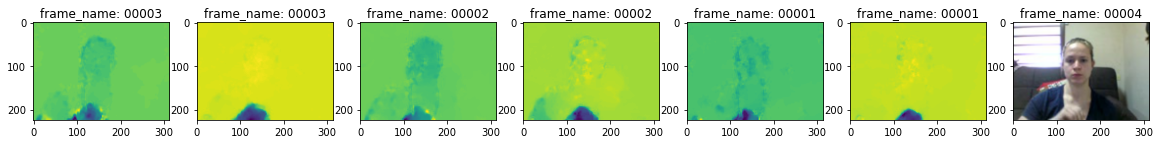

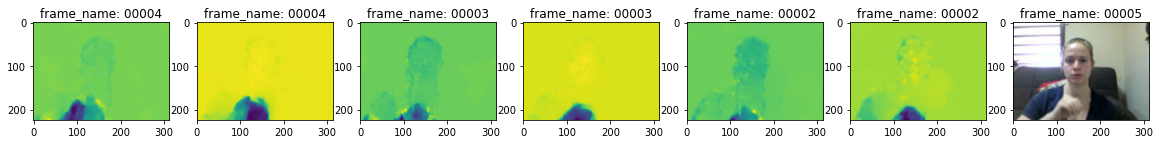

ROW INDEX: 1
min_frame_idx: 13, max_frame_idx: 15


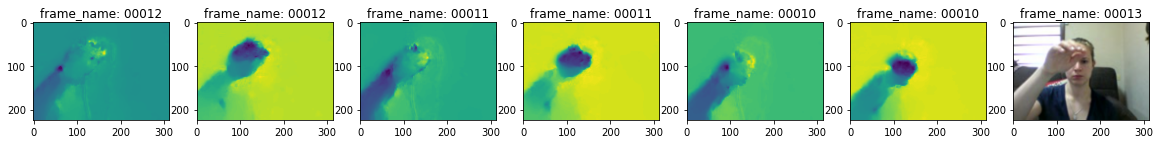

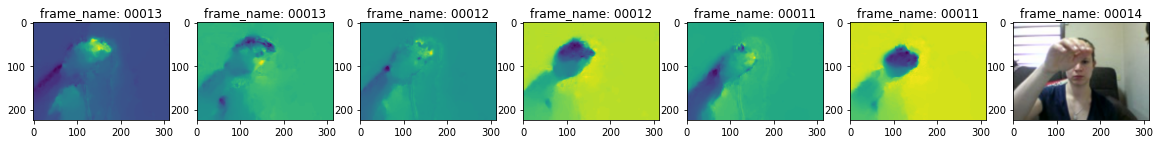

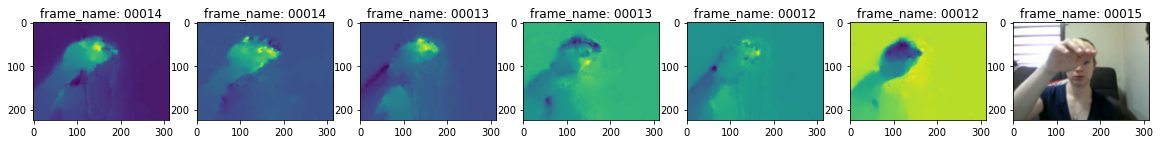

ROW INDEX: 2
min_frame_idx: 24, max_frame_idx: 26


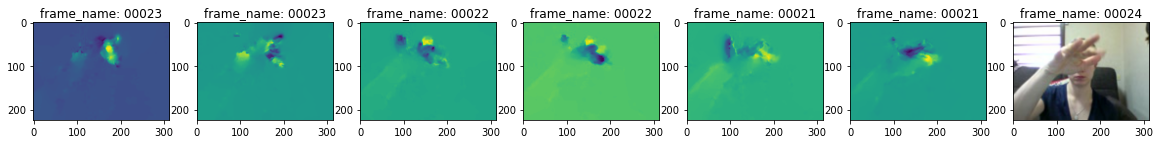

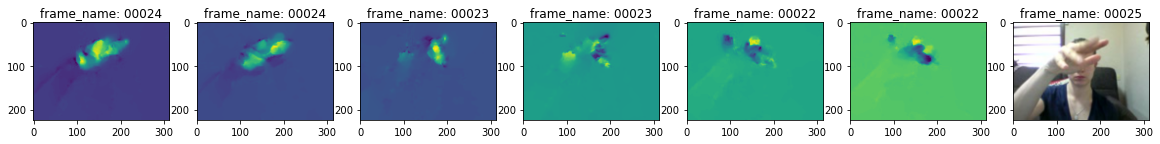

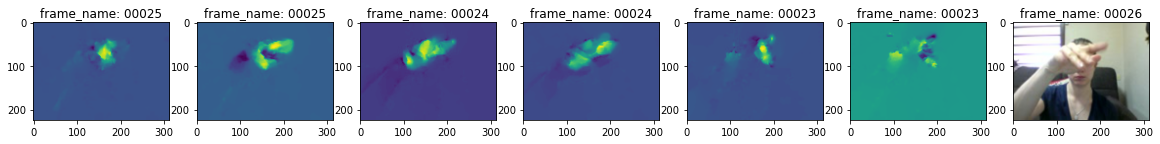

ROW INDEX: 3
min_frame_idx: 35, max_frame_idx: 36


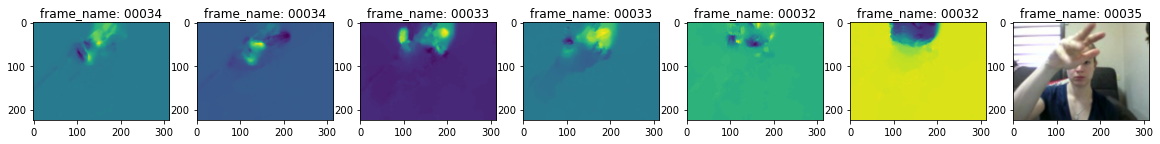

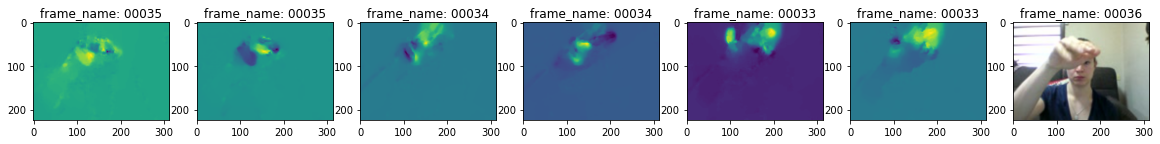

In [81]:
def create_images(folder, keyframe_idxs, n_frames, crop_resize=True, frame_range=0, debug=False):
    res = []
    # For each keyframe idx
    for row_idx, keyframe_idx in enumerate(keyframe_idxs):
        print(f'ROW INDEX: {row_idx}')
        
        min_frame_idx = max(N_OPTICAL_FLOW_FRAMES + 1, keyframe_idx - frame_range, min(keyframe_idxs))
        # maximum frame index is number of frames
        max_frame_idx = min(n_frames, keyframe_idx + 1, max(keyframe_idxs))
        print(f'min_frame_idx: {min_frame_idx}, max_frame_idx: {max_frame_idx}')
        frame_options = []
        for frame_idx in range(min_frame_idx, max_frame_idx + 1):
            fig, ax = plt.subplots(1, 7, figsize=(20,5))
            mff = []
            
            # OPTICAL FLOW
            of_frame_idx = 1
            ofs_created = 0
            while ofs_created < N_OPTICAL_FLOW_FRAMES:
                # read optical flow frames
                frame_name = str(frame_idx - of_frame_idx).rjust(5, '0')
                frame_ofx = load_image(f'{DATASET_FOLDER}/flow/x/{folder}/{frame_name}.jpg', crop_resize)
                frame_ofy = load_image(f'{DATASET_FOLDER}/flow/y/{folder}/{frame_name}.jpg', crop_resize)
                ax[2*ofs_created].imshow(frame_ofx)
                ax[2*ofs_created].set_title(f'frame_name: {frame_name}')
                ax[1+2*ofs_created].imshow(frame_ofy)
                ax[1+2*ofs_created].set_title(f'frame_name: {frame_name}')
                
                # Check Null Optical Flow Frame  or (frame_idx - of_frame_idx) - (N_OPTICAL_FLOW_FRAMES - ofs_created) < 1
                if frame_ofx.std() > 0 and frame_ofy.std() > 0 or (frame_idx - of_frame_idx) - (N_OPTICAL_FLOW_FRAMES - ofs_created) < 1:
                    # assign optical flow frames to result
                    mff = [frame_ofx, frame_ofy] + mff
                    ofs_created += 1
                    
                of_frame_idx += 1
            
            # RGB frame
            frame_name = str(frame_idx).rjust(5, '0')
            frame_rgb = load_image(f'{DATASET_FOLDER}/rgb/{folder}/{frame_name}.jpg', crop_resize)
            # plot RGB image
            ax[6].imshow(frame_rgb)
            ax[6].set_title(f'frame_name: {frame_name}')
            plt.show()
            
            mff += [frame_rgb]
            
            # add mff to frame options
            frame_options.append(mff)
            
        res.append(frame_options)
            
    return res

keyframe_idxs = get_keyframe_idxs_of_kfe(folder, n_frames)
print(f'keyframe_idxs: {keyframe_idxs}')
res = create_images(folder, keyframe_idxs, n_frames, frame_range=1)